# Cleaning and Augmentation
This notebook is meant to read in the data downloaded from reddit and prepare it for analysis by cleaning it and doing some computation.

## Setup

In [124]:
import pandas as pd
import datetime
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
import collections

In [125]:
# Change this to analyze something else

# ## a big one:
# subreddit = "enlightenedbirdmen"
# download_date_string = "19.12.04-14:27:14"

# ## a meduim one:
# subreddit = "justwriterthings"
# download_date_string = "19.12.04-10:30:56"

## a small one:
subreddit = "The_B_Emoji"
download_date_string = "19.12.04-09:28:30"

In [126]:
# Constants
data_directory = "downloads/"
submissions_suffix = "-submissions-" + download_date_string + ".csv"
comments_suffix = "-comments-" + download_date_string + ".csv"

## Read the Data

In [127]:
# Read the submissions
submissions_file = data_directory + subreddit + submissions_suffix
submissions = pd.read_csv(submissions_file, index_col=0)
submissions.head()

,submission_id,user,utc,score,title,body,subreddit
0,e2yzip,greendirtbike,1.574953e+09,25,Yall 🅱️etter 🅱️e supporting local 🅱️usiness th...,They need to make a living just as much as the...,The_B_Emoji
1,e2nsue,ConnerFromCyberLife,1.574893e+09,36,🅱️he 🅱️ood 🅱️hit,NaN,The_B_Emoji
2,e0me00,Colteor,1.574536e+09,28,With 🅱️ you say?,NaN,The_B_Emoji
3,e07yk0,ConnerFromCyberLife,1.574459e+09,46,🅱️on’t 🅱️et 🅱️his 🅱️u🅱️reddit 🅱️ie,NaN,The_B_Emoji
4,dykruw,Colteor,1.574172e+09,28,🅱️,NaN,The_B_Emoji


In [128]:
# Read the comments
comments_file = data_directory + subreddit + comments_suffix
comments = pd.read_csv(comments_file, index_col=0)
comments.head()

,comment_id,submission_id,user,utc,score,body
0,f8yxtay,t3_e2yzip,skelly46,1.574954e+09,6,🅱️ye 🅱️ye 🅱️ig 🅱️usiness
1,f90phhs,t3_e2yzip,the_thou_factor,1.574976e+09,1,Jeff 🅱️ezos can suck my 🅱️ig cock. With the ne...
2,f90pgac,t3_e2yzip,Lapis-Blaze-Yt,1.574976e+09,0,I 🅱️re♿️er 🅱️🅾️mmunism
3,f8wlkrh,t3_e2nsue,Bored_Ford,1.574894e+09,5,"Oh 🅱️a🅱️y, that's 🅱️ank"
4,f8wlzva,t3_e2nsue,IPorK,1.574894e+09,4,Oh s🅱️it that's 🅱️eep


## Data Cleaning

In [129]:
# Remove the t3_ prefix from comment submission ids
comments["submission_id"] = comments["submission_id"].apply(lambda s: s.split("t3_")[1])

# Empty content should be the empty string - not nan
submissions['body'] = submissions['body'].fillna(value="")
comments['body'] = comments['body'].fillna(value="")

## Data Conversion

In [130]:
# Convert utc to date
submissions['date'] = submissions['utc'].apply(datetime.datetime.utcfromtimestamp)
comments['date'] = comments['utc'].apply(datetime.datetime.utcfromtimestamp)
#submissions.head()
comments.head()

,comment_id,submission_id,user,utc,score,body,date
0,f8yxtay,e2yzip,skelly46,1.574954e+09,6,🅱️ye 🅱️ye 🅱️ig 🅱️usiness,2019-11-28 15:18:39
1,f90phhs,e2yzip,the_thou_factor,1.574976e+09,1,Jeff 🅱️ezos can suck my 🅱️ig cock. With the ne...,2019-11-28 21:12:02
2,f90pgac,e2yzip,Lapis-Blaze-Yt,1.574976e+09,0,I 🅱️re♿️er 🅱️🅾️mmunism,2019-11-28 21:11:49
3,f8wlkrh,e2nsue,Bored_Ford,1.574894e+09,5,"Oh 🅱️a🅱️y, that's 🅱️ank",2019-11-27 22:27:08
4,f8wlzva,e2nsue,IPorK,1.574894e+09,4,Oh s🅱️it that's 🅱️eep,2019-11-27 22:32:03


In [131]:
# Ensure time ordering of submissions
submissions = submissions.sort_values(['date'], ascending = [1]).reset_index()
submissions.head()

,index,submission_id,user,utc,score,title,body,subreddit,date
0,281,aag3pi,Mods_are_gay42069,1.546043e+09,8,🅱️,🅱️,The_B_Emoji,2018-12-29 00:25:14
1,280,aagdcr,skelly46,1.546045e+09,6,Let's Get It,Let's get this 🅱️read 🅱️ois,The_B_Emoji,2018-12-29 00:58:13
2,279,ajczbx,HeraldOfTheDankWeb,1.548340e+09,91,Post whatever the fuck you want.,"This will probably turn out bad, but who gives...",The_B_Emoji,2019-01-24 14:33:41
3,278,ajd8gx,retro_gatling,1.548342e+09,4,cringe,,The_B_Emoji,2019-01-24 15:01:28
4,277,ajd97x,pinballmanfan,1.548342e+09,16,epic title,,The_B_Emoji,2019-01-24 15:03:38


## Pagerank
This uses [networkx](https://networkx.github.io/documentation/networkx-1.10/index.html)

In [132]:
# # proff that directed edges are defined (start, end)
# d = nx.DiGraph()
# d.add_node(1)
# d.add_node(2)
# d.add_edge(1, 2)
# nx.draw_networkx(d)

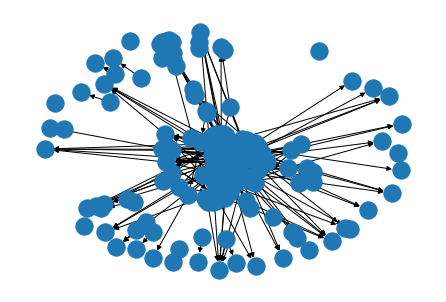

In [133]:
# Start by creating a directed graph
g = nx.DiGraph()

# Each user is a node in the graph
g.add_nodes_from(set(submissions['user'].append(comments['user'])))

# Each comment is a directed edge
pd.merge(submissions, comments, on='submission_id') \
    .apply(lambda row: g.add_edge(row["user_y"], row["user_x"]), axis=1)

# Visualize the graph
nx.draw(g)
plt.show()

In [134]:
# Now lets calculate pagerank
pagerank = nx.pagerank(g)
#pagerank # uncomment to preview

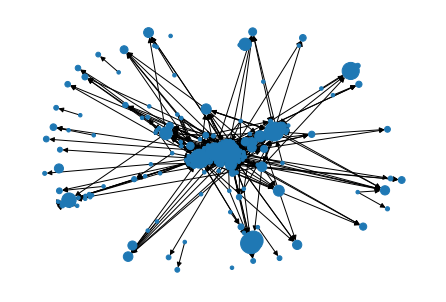

In [135]:
# and visualize it - 8000 is just a scaling factor to make the dots visible
nx.draw(g, node_size=[8000 * x for x in pagerank.values()])
plt.show()

## KLD

In [136]:
# Start by defining post content
submissions['content'] = submissions['body'] + submissions['title']

In [137]:
# A helper for calculating word frequencies
def p_dist(content):
    words = content.split() # tokenize by splitting on whitespace
    counts = collections.Counter(words)
    total = sum(counts.values())
    return {word: count / total for word, count in counts.items()}

# Calculate the word frequencies for every submission
submissions['word_p_dist'] = submissions['content'].apply(p_dist)

In [138]:
# And now calculating entropy is easy
submissions['entropy'] = submissions['word_p_dist'].apply(lambda d: scipy.stats.entropy(list(d.values()), base=2))

In [139]:
# A constant because 0 probabilities break math
infinitesimal = 0.0001

# Helper for calculating kld
def kld(word_freq1, word_freq2):
    if word_freq1 == None or word_freq2 == None:
        return np.nan
    p_dist1 = []
    p_dist2 = []
    for (word, freq) in word_freq1.items():
        p_dist1.append(freq)
        p_dist2.append(infinitesimal if not word in word_freq2 else word_freq2[word])
    for (word, freq) in word_freq2.items():
        if not word in word_freq1:
            p_dist1.append(infinitesimal)
            p_dist2.append(freq)
    return scipy.stats.entropy(p_dist1, p_dist2, base=2)

## simple test - should be equal
# scipy.stats.entropy([0.25, 0.75, infinitesimal], [0.5, 0.4, 0.1], base=2)
# kld({'a':0.25, 'b':0.75}, {'a':0.5, 'b':0.4, 'c':0.1})

In [140]:
# Calculate novelty
submissions['prev_submission_dist'] = submissions['word_p_dist'].shift(1).replace(to_replace={float("Nan"): None})
submissions['novelty'] = submissions.apply(lambda row: kld(row['word_p_dist'], row['prev_submission_dist']), axis=1)
submissions = submissions.drop('prev_submission_dist', axis=1)

In [141]:
# And calculate transience
submissions['next_submission_dist'] = submissions['word_p_dist'].shift(-1).replace(to_replace={float("Nan"): None})
submissions['transience'] = submissions.apply(lambda row: kld(row['word_p_dist'], row['next_submission_dist']), axis=1)
submissions = submissions.drop('next_submission_dist', axis=1)

In [142]:
# Calculate novelty based on multiple previous submissions
window_size = 5

# Helper to average kld of multiple other submissions
def average_kld(of_dist, given_dists):
    if any(map(lambda x: x == None, given_dists)):
        return float("Nan")
    return np.mean(list(map(lambda given_dist: kld(of_dist, given_dist), given_dists)))

# Get the distributions of earlier submissions
submissions['prev_dists'] = submissions['word_p_dist'].apply(lambda x: list()) # get a sequence of empty lists
for i in range(1, window_size + 1):
    submissions['prev_dists'] = submissions['prev_dists'].combine(submissions['word_p_dist'].shift(i).replace(to_replace={float("Nan"): None}), lambda x, y: x + [y])

# And calculate novelty based on that window
submissions['novelty_5'] = submissions.apply(lambda row: average_kld(row['word_p_dist'], row['prev_dists']), axis=1)

# Cleanup
submissions = submissions.drop('prev_dists', axis=1)

In [143]:
# Get the distributions of later submissions
submissions['next_dists'] = submissions['word_p_dist'].apply(lambda x: list()) # get a sequence of empty lists
for i in range(1, window_size + 1):
    submissions['next_dists'] = submissions['next_dists'].combine(submissions['word_p_dist'].shift(-1 * i).replace(to_replace={float("Nan"): None}), lambda x, y: x + [y])

# And calculate novelty based on that window
submissions['transience_5'] = submissions.apply(lambda row: average_kld(row['word_p_dist'], row['next_dists']), axis=1)

# Cleanup
submissions = submissions.drop('next_dists', axis=1)

In [144]:
# Add a column for the difference between novelty and transience - let's call this... the impact
submissions['impact'] = submissions['novelty'] - submissions['transience']
submissions['impact_5'] = submissions['novelty_5'] - submissions['transience_5']

## Grouping By Users

In [171]:
user_submissions = submissions.groupby("user").apply(lambda g: pd.Series(
    {
        'num_posts': g['title'].size,
        'max_score': g['score'].max(),
        'mean_score': g['score'].mean(),
        'min_score': g['score'].min(),
        'mean_length': g.apply(lambda row: len(row['title'] + row['body']), axis=1).mean(),
        'pagerank': pagerank[g['user'].iloc[0]], # weird indexing gets username and then finds pagerank for that user
        'mean_impact': g['impact'].mean(),
        'mean_novelty': g['novelty'].mean(),
        'mean_transience': g['transience'].mean(),
        'mean_impact_5': g['impact_5'].mean(),
        'mean_novelty_5': g['novelty_5'].mean(),
        'mean_transience_5': g['transience_5'].mean()
    }
))
user_submissions.head()

,num_posts,max_score,mean_score,min_score,mean_length,pagerank,mean_impact,mean_novelty,mean_transience
user,,,,,,,,,
AirHamyes,1.0,24.0,24.000000,24.0,88.000000,0.006448,-0.619726,8.758637,9.378363
An_Und3adMann,1.0,10.0,10.000000,10.0,2.000000,0.001550,-0.991175,2.577601,3.568776
Andes1te,9.0,27.0,11.111111,4.0,52.444444,0.019543,-0.295849,10.330189,10.626038
Awesomeman235ify,1.0,4.0,4.000000,4.0,30.000000,0.007054,-0.009953,13.270221,13.280174
BluePharoh,3.0,57.0,23.666667,2.0,66.666667,0.011617,0.526958,9.475817,8.948858


In [172]:
user_comments = comments.groupby("user").apply(lambda g: pd.Series(
    {
        'num_comments': g['body'].size,
        'max_score': g['score'].max(),
        'mean_score': g['score'].mean(),
        'min_score': g['score'].min(),
        'mean_length': g['body'].apply(len).mean(),
        'pagerank': pagerank[g['user'].iloc[0]] # weird indexing gets username and then finds pagerank for that user
    }
))
user_comments.head()

,num_comments,max_score,mean_score,min_score,mean_length,pagerank
user,,,,,,
-San-Holo-,1.0,1.0,1.000000,1.0,22.000000,0.001550
ATangerineMann,1.0,2.0,2.000000,2.0,7.000000,0.001550
Andes1te,6.0,3.0,2.333333,2.0,15.500000,0.019543
ArtaxYT,1.0,2.0,2.000000,2.0,9.000000,0.001550
Awesomeman235ify,3.0,2.0,1.333333,1.0,12.333333,0.007054


## Merging the Tables

In [173]:
users = user_submissions.join(user_comments, how="outer", lsuffix="_submissions", rsuffix="_comments")

## Clean up after the merge

# outer join means pagerank may only be defined in one case and not the other - combine them
users['pagerank'] = users.apply(lambda row: row['pagerank_comments'] if np.isnan(row['pagerank_submissions']) else row['pagerank_submissions'], axis=1)
users = users.drop('pagerank_submissions', axis=1)
users = users.drop('pagerank_comments', axis=1)
users.head()

,num_posts,max_score_submissions,mean_score_submissions,min_score_submissions,mean_length_submissions,mean_impact,mean_novelty,mean_transience,num_comments,max_score_comments,mean_score_comments,min_score_comments,mean_length_comments,pagerank
user,,,,,,,,,,,,,,
-San-Holo-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.000000,1.0,22.0,0.001550
ATangerineMann,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.000000,2.0,7.0,0.001550
AirHamyes,1.0,24.0,24.000000,24.0,88.000000,-0.619726,8.758637,9.378363,NaN,NaN,NaN,NaN,NaN,0.006448
An_Und3adMann,1.0,10.0,10.000000,10.0,2.000000,-0.991175,2.577601,3.568776,NaN,NaN,NaN,NaN,NaN,0.001550
Andes1te,9.0,27.0,11.111111,4.0,52.444444,-0.295849,10.330189,10.626038,6.0,3.0,2.333333,2.0,15.5,0.019543


## EDA

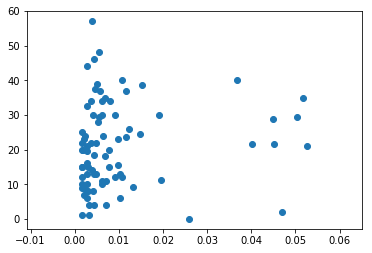

In [148]:
# mean score vs pagerank
plt.scatter(x=users['pagerank'], y=users['mean_score_submissions'])
plt.show()

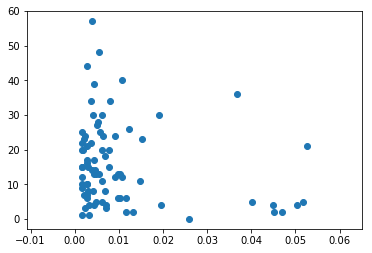

In [149]:
# min score vs pagerank
plt.scatter(x=users['pagerank'], y=users['min_score_submissions'])
plt.show()

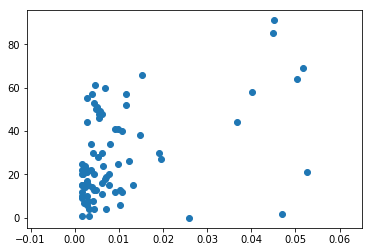

In [150]:
# max score vs pagerank
plt.scatter(x=users['pagerank'], y=users['max_score_submissions'])
plt.show()

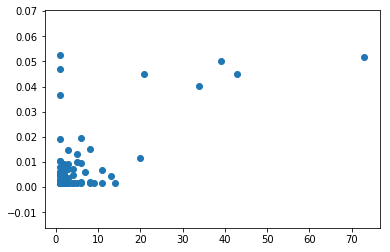

In [151]:
# number of comments vs pagerank
plt.scatter(x=users['num_comments'], y=users['pagerank'])
plt.show()

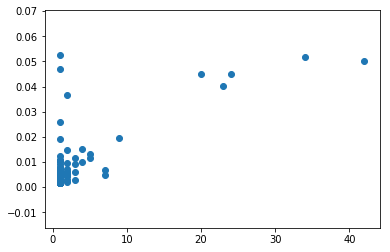

In [152]:
# number of posts vs pagerank - should be correlated (more submissions to comment on)
plt.scatter(x=users['num_posts'], y=users['pagerank'])
plt.show()
# okay, my hypothesis was wrong...

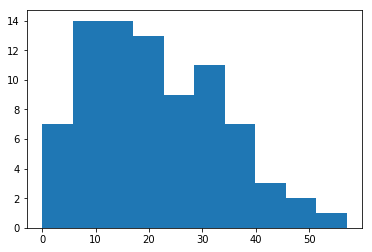

In [153]:
plt.hist(users['mean_score_submissions'])
plt.show()

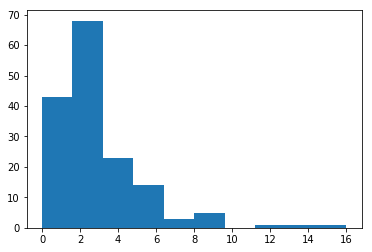

In [154]:
plt.hist(users['mean_score_comments'])
plt.show()

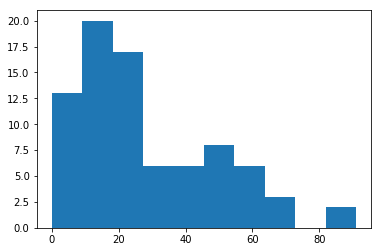

In [155]:
plt.hist(users['max_score_submissions'])
plt.show()

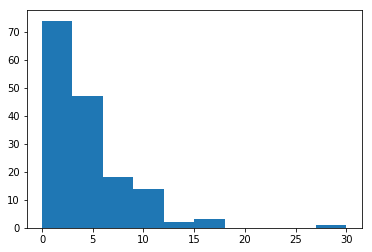

In [156]:
plt.hist(users['max_score_comments'])
plt.show()

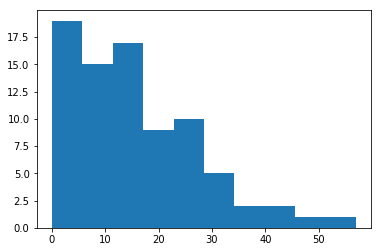

In [157]:
plt.hist(users['min_score_submissions'])
plt.show()

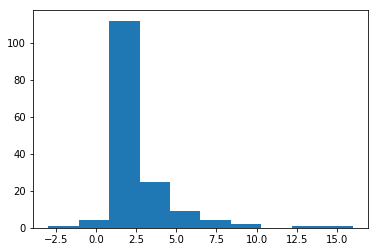

In [158]:
plt.hist(users['min_score_comments'])
plt.show()

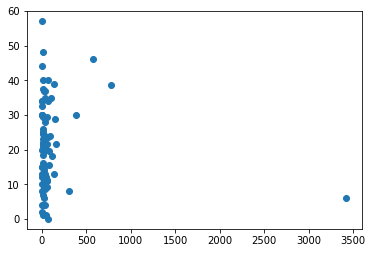

In [159]:
plt.scatter(x=users['mean_length_submissions'], y=users['mean_score_submissions'])
plt.show()

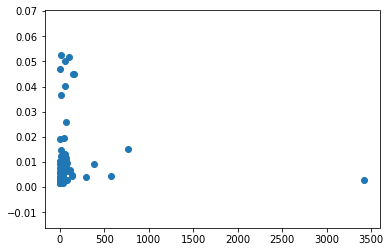

In [160]:
plt.scatter(x=users['mean_length_submissions'], y=users['pagerank'])
plt.show()

## Just Submission Stuff

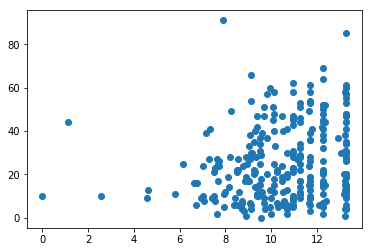

In [161]:
plt.scatter(x=submissions['novelty'], y=submissions['score'])
plt.show()

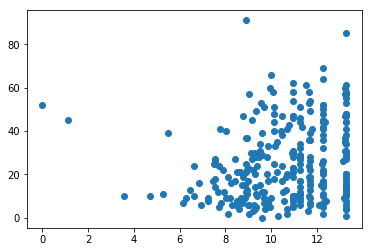

In [162]:
plt.scatter(x=submissions['transience'], y=submissions['score'])
plt.show()

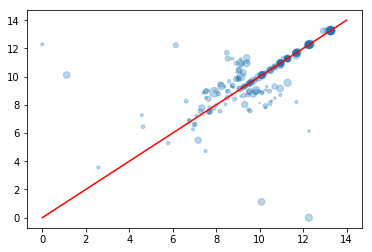

In [163]:
# novelty-transcience plot
plt.scatter(x=submissions['novelty'], y=submissions['transience'], s=submissions['score'], alpha=0.3)

# add line of equality
domain = np.arange(0, 15)
plt.plot(domain, domain, color='red')
plt.show()

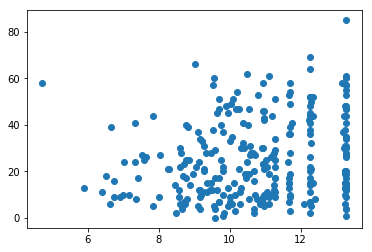

In [164]:
plt.scatter(x=submissions['novelty_5'], y=submissions['score'])
plt.show()

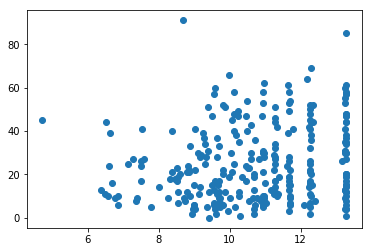

In [165]:
plt.scatter(x=submissions['transience_5'], y=submissions['score'])
plt.show()

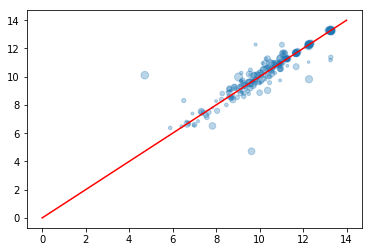

In [166]:
# novelty-transcience plot
plt.scatter(x=submissions['novelty_5'], y=submissions['transience_5'], s=submissions['score'], alpha=0.3)

# add line of equality
domain = np.arange(0, 15)
plt.plot(domain, domain, color='red')
plt.show()

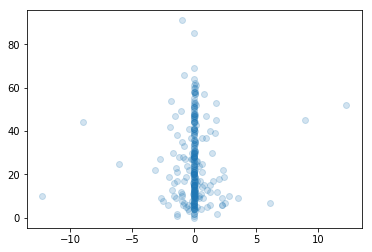

In [167]:
plt.scatter(x=submissions['impact'], y=submissions['score'], alpha=0.2)
plt.show()

## Users and KLD

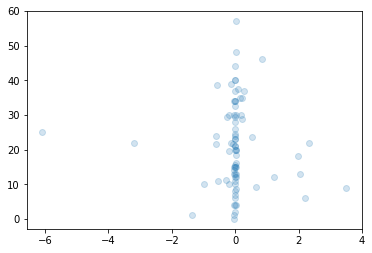

In [170]:
plt.scatter(x=users['mean_impact'], y=users['mean_score_submissions'], alpha=0.2)
plt.show()

In [ ]:
# novelty-transcience plot
plt.scatter(x=submissions['novelty_5'], y=submissions['transience_5'], s=submissions['score'], alpha=0.3)

# add line of equality
domain = np.arange(0, 15)
plt.plot(domain, domain, color='red')
plt.show()